In [5]:
import numpy as np
from scipy import optimize as opt
from collections import namedtuple
from matplotlib import pyplot as plt

from LinApp_FindSS import LinApp_FindSS
from LinApp_Deriv import LinApp_Deriv
from LinApp_Solve import LinApp_Solve

### Exercise 5

In [6]:
# Use a root finder to optimize over the 3 equations from part 1.
params5 = [2.5, 1.5, .98, .4, .5, .10, 0, .05]
def diff5(varvec, params):
    k, r, w = varvec[0], varvec[1], varvec[2]
    gamma, xi, beta, alpha, a, delta, zbar, tau = params
    eulerdiff = 1 - beta * ((r - delta) * (1 - tau) + 1)
    rdiff = r - alpha * k ** (alpha - 1)
    wdiff = w - (1 - alpha) * k ** alpha
    outvec = np.array([eulerdiff, rdiff, wdiff])
    return outvec

roots = opt.root(diff5, [1, 1, 1], args = params5).x
k_ss = roots[0]
r_ss = roots[1]
w_ss = roots[2]
i_ss = k_ss ** .4
y_ss = k_ss * .1
print(" k_ss =", k_ss, "\n r_ss =", r_ss, "\n w_ss =", w_ss, "\n y_ss =", y_ss, "\n i_ss =", i_ss)


 k_ss = 7.287497950692919 
 r_ss = 0.12148227712137491 
 w_ss = 1.327952768351301 
 y_ss = 0.7287497950692919 
 i_ss = 2.2132546139188345


## Exercise 6

In [7]:
params6 = [2.5, 1.5, .98, .4, .5, .10, 0, .05]

#Define tax function
def T(k, r, w, l, params):
    gamma, xi, beta, alpha, a, delta, zbar, tau = params
    T = tau * ( w*l + (r - delta) * k)
    return T

#print(T(1, 1, 1, 1, params6))

#define consumption function (assume T is zero)
def cons(k, r, w, l, params):
    gamma, xi, beta, alpha, a, delta, zbar, tau = params
    c = (1 - tau) * (w * l + (r - delta) * k) - T(k, r, w, l, params6)
    return c

print(cons(1, 1, 1, 1, params6))

#Define Difference function
def diff6(varvec, params):
    k, r, w, l = varvec[0], varvec[1], varvec[2], varvec[3]
    gamma, xi, beta, alpha, a, delta, zbar, tau = params
    c = cons(k, r, w, l, params6)
    cldiff = w * (1 - tau) * c ** (-gamma) + a * (1 - l) ** (-gamma)
    eulerdiff = c ** (-gamma) - c**(-gamma) * (- beta) * ((r - delta) * (1 - tau) + 1)
    rdiff = r - alpha * k ** (alpha - 1)
    wdiff = w - (1 - alpha) * k ** alpha
    outvec = np.array([cldiff, eulerdiff, rdiff, wdiff])
    return outvec

diff6([.4, .4, .4, .4], params6)
#roots = opt.root(diff6, [1, 1, 1, 1], args = params6).x

1.71


array([ 1.37132122e+01,  7.08716511e+01, -2.93144843e-01, -1.58869059e-02])

### Something is likely broken above!

## Baseline Tax Model

This is from Chase's notebook on Github! Had to add a few things.

In [8]:
# Parametrize
params = ["a", "alpha", "beta", "delta", "gamma", "rho", "sigma", "tau", "xi", "zbar"]
BaselineModel = namedtuple("BaselineModel", params)

m = BaselineModel(0.50, 0.40, 0.98, 0.10, 2.50, 0.90, 0.02, 0.05, 1.5, 0.0)

Define Functions:

In [9]:
#Utility/Production Functions
def util(m, c, l):
    uc = (c**(1.0 - m.gamma) - 1.0) / (1.0 - m.gamma)
    ul = m.a * ((1.0 - l)**(1.0 - m.xi) - 1.0) / (1.0 - m.xi)
    return uc + ul

def du_dc(m, c, l):
    return c**(-m.gamma)

def du_dl(m, c, l):
    return - m.a * (1.0 - l)**(-m.xi)

def f(m, k, l, z):
    return k**m.alpha * (l * np.exp(z))**(1.0 - m.alpha)

def df_dk(m, k, l, z):
    return m.alpha * (l/k * np.exp(z))**(1.0 - m.alpha)

def df_dl(m, k, l, z):
    return (1.0 - m.alpha) * np.exp(z)**(1.0 - m.alpha) * (k / l)**m.alpha

#Characteristic Equations
def Definitions(m, ktp1, kt, lt, zt):
    wt = df_dl(m, kt, lt, zt)
    rt = df_dk(m, kt, lt, zt)
    Tt = m.tau * (wt*lt + (rt - m.delta)*kt)
    ct = (1 - m.tau) * (wt*lt + (rt - m.delta)*kt) + kt + Tt - ktp1
    ct = max(ct, 1e-8)
    return ct, rt, Tt, wt

def CharacteristicEquations(ktp2, ltp1, ktp1, lt, kt, ltm1, ztp1, zt, m):
    ct, rt, Tt, wt = Definitions(m, ktp1, kt, lt, zt)
    ctp1, rtp1, Ttp1, wtp1 = Definitions(m, ktp2, ktp1, ltp1, ztp1)
    rr_tp1 = (rtp1 - m.delta)*(1 - m.tau) + 1.0

    intertemporal_ee = du_dc(m, ct, lt) - m.beta*du_dc(m, ctp1, ltp1)*rr_tp1
    intratemporal_ee = du_dl(m, ct, lt) + du_dc(m, ct, lt)*wt*(1.0 - m.tau)

    return np.array([intertemporal_ee, intratemporal_ee])

### Exercise 4

In [10]:
# Solve the Steady-state
def solve_ss(m):
    solve_me = lambda x: CharacteristicEquations(x[0], x[1], x[0], x[1], x[0], x[1], m.zbar, m.zbar, m)
    sol = opt.root(solve_me, np.array([0.5, 0.85]))
    return sol.x

kbar, lbar = solve_ss(m)
cbar, rbar, Tbar, wbar = Definitions(m, kbar, kbar, lbar, m.zbar)

print("Steady State Capital:", kbar, "\nSteady state labor:", lbar)

Steady State Capital: 4.225229026815977 
Steady state labor: 0.5797914531671479


### Exercise 5

In [11]:
''' 
dy/dx will be returned as a matrix of derivatives with the columns 
being one element of x, and the rows being one element of y. (basically
a derivative matrix) The xs are in the order as defined in the namedtuple.
The ys are in the same order as they are in the problem, see the output
of "get_outcomes"
'''

def get_outcomes(m):
    '''
    This is the function I'll be differentiating. It takes the parameters
    m as inputs, and returns the important outputs as a list in the 
    appropriate order.
    '''
    kbar, lbar = solve_ss(m)
    cbar, rbar, Tbar, wbar = Definitions(m, kbar, kbar, lbar, m.zbar)
    ybar = f(m, kbar, lbar, m.zbar)
    ibar = ybar - cbar
    return kbar, cbar, rbar, wbar, lbar, Tbar, ybar, ibar

def Dmat5(x, y, f, dist = 10e-3):
    m = len(y)
    n = len(x)
    #Initialize Jacobian
    Dmat = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            xnew = np.array(x)
            xnew[j] = xnew[j] - dist
            xnew = BaselineModel(*xnew)
            Dmat[i, j] = (f(x)[i] - f(xnew)[i]) / dist
    return Dmat

ss = get_outcomes(m)
Derivs = Dmat5(m, ss, get_outcomes)
print(" Steady state values: \n", ss, "\n Derivatives: \n", Derivs)
print("Examples: \n Derivative of interest rate w.r.t beta: \n", Derivs[2, 2], \
      "\n Derivative of output w.r.t zbar: \n", Derivs[6, 9], \
      "\n Derivative of capital stock w.r.t. alpha: \n", Derivs[0, 1], \
      "\n Derivative of consumption w.r.t. gamma: \n", Derivs[1, 4], \
      "\n Derivative of total tax w.r.t. tau \n", Derivs[5, 7])

print("That consumption number looks... weird... but everything else seems like it's going the correct direction!")

 Steady state values: 
 (4.225229026815977, 0.8607032061550788, 0.12148227712083877, 1.3279527683552124, 0.5797914531671479, 0.04303516030775391, 1.2832261088366759, 0.4225229026815971) 
 Derivatives: 
 [[-1.86765917e+00  2.50870080e+01  5.82324425e+01 -5.33532984e+01
   1.39005241e-01  0.00000000e+00  0.00000000e+00 -2.31059680e+00
  -8.04025727e-01  2.83121470e+00]
 [-3.80452802e-01  2.01540367e+00  1.77750090e+00 -3.73022759e+00
   2.83161591e-02  0.00000000e+00  0.00000000e+00 -2.33015289e-01
  -1.63784618e-01  5.76734552e-01]
 [ 2.02608763e-10 -6.37803699e-10 -1.10733387e+00  1.00000000e+00
   2.06792916e-11  0.00000000e+00  0.00000000e+00  2.23773722e-02
  -5.18127208e-11 -3.54091756e-11]
 [-1.47653001e-09  4.21014717e+00  7.50256090e+00 -7.82696716e+00
  -1.50746082e-10  0.00000000e+00  0.00000000e+00 -1.63325789e-01
   3.77564646e-10  1.32133508e+00]
 [-2.56282632e-01 -7.50109856e-01  1.68027648e-01  1.38948957e+00
   1.90744811e-02  0.00000000e+00  0.00000000e+00 -1.38200975e-

## Exercise 6

We implement the method outlined in Chase's notebooks.

In [12]:
# Implement Chase's method:

def derivative(f, x, xtilde):
    return (f(x) - f(xtilde)) / np.sum(x - xtilde)

def linearize(m, kbar, lbar, eps=1e-6):
    # Compute ss gamma
    x = np.array([kbar, lbar, kbar, lbar, kbar, lbar, 0.0, 0.0])
    Gamma_ss = CharacteristicEquations(kbar, lbar, kbar, lbar, kbar, lbar, 0.0, 0.0, m)

    # Allocate space for derivative matrix
    neq = len(Gamma_ss)
    Dmat = np.empty((neq, 8))

    CEsplat = lambda x: CharacteristicEquations(*list(x), m)
    for i in range(8):
        xtilde = np.array([kbar, lbar, kbar, lbar, kbar, lbar, 0.0, 0.0])
        xtilde[i] += eps
        Dmat[:, i] = derivative(CEsplat, x, xtilde)

    F = Dmat[:, :2]
    G = Dmat[:, 2:4]
    H = Dmat[:, 4:6]
    L = Dmat[:, 6]
    M = Dmat[:, 7]
    #N is 1x1 so just a constant
    N = m.rho
    
    return F, G, H, L, M, N

F, G, H, L, M, N = linearize(m, kbar, lbar)
print(" F= \n", F, \
      "\n G = \n", G, \
      "\n H = \n", H, \
      "\n L = \n", L, \
      "\n M = \n", M, \
      "\n N = \n", N)


 F= 
 [[-4.22623769  5.44191867]
 [-0.         -0.        ]] 
 G = 
 [[  8.5666152   -5.61221554]
 [  5.33163184 -14.89888287]] 
 H = 
 [[-4.31700912 -0.        ]
 [-5.27237248 -0.        ]] 
 L = 
 [ 3.1551835 -0.       ] 
 M = 
 [-3.25392039 -3.00365571] 
 N = 
 0.9


I did this next part with Tim. It was incredibly annoying to try to actually use the package, given that we wrote all our code above in different formats. However, after some trial and error, we discovered that the arguments for LinApp_Solve that we *hadn't* used were all just supposed to be empty matrices... so we *think* that our matrices for P and Q here are correct. 

In [13]:
#Now we have FGHLM we can try to solve for P and Q
AA=np.zeros((0,2))
BB=np.zeros((0,2))
CC=np.zeros((0,0))
DD=np.zeros((0,1))
FF=F
GG=G
HH=H
JJ=np.zeros((2,0))
KK=np.zeros((2,0))
LL = np.zeros((2,1))
LL[0,0] =L[0]
LL[1,0] = L[1]
MM = np.zeros((2,1))
MM[0,0] =M[0]
MM[1,0] = M[1]
WW=np.zeros((0,0)) #empty list or floating point
TT=np.array([1e-8, 1e-8])
NN= N
Zbar=np.array([0])
Sylv = 0

PP, QQ, UU, RR, SS, VV = \
    LinApp_Solve(AA,BB,CC,DD,FF,GG,HH,JJ,KK,LL,MM,WW,TT,NN,Zbar,Sylv)
print ('PP:',PP)
print ('QQ', QQ)
print ('RR:',RR)
print ('SS', SS)

PP: [[ 0.91529275  0.        ]
 [-0.02633543  0.        ]]
QQ [[ 0.54504859]
 [-0.00655467]]
RR: []
SS []


In [96]:
#OK! I need to make some functions to iterate my economy by 1 period.
P, Q = PP, QQ
k_ss = kbar
l_ss = lbar

def statenext(m, X, z):
    '''
    Takes vector of X (absolute deviation of capital from steady-state)
    for one period and shock z for the next period and gives vector of X
    for next period. Uses policy function.
    '''
    newstate = P @ X + (Q * z).T
    knext = newstate[0][0]
    lnext = newstate[0][1]
    return knext, lnext
    
def znext(m, z):
    '''
    Takes value of z for one period and gives value of z for next period
    '''
    return m.rho * z + np.random.normal(0, m.sigma)

def simtimeseries(m, X, Z, T):
    '''
    This function takes a given initial state vector X and 
    simulates the economy for T periods given parameters m.
    
    NOTE: X and Z are ABSOLUTE DEVIATIONS from the steady state!
    '''
    X_t = X
    X_tp1 = X_t
    z_t = Z
    klist = []
    llist = []
    clist = []
    rlist = []
    wlist = []
    ylist = []
    ilist = []
    for i in range(T):
        #Get next period choices, shock
        X_tp1 = statenext(m, X_t, z_t) 
        z_tp1 = znext(m, z_t)
        #Store period's values        
        k_t = X_t[0] + k_ss
        k_tp1 = X_tp1[0] + k_ss
        l_t = X_t[1] + l_ss
        cstore, rstore, Tstore, wstore = Definitions(m, k_tp1, k_t, l_t, z_t)
        istore = k_tp1 - (1 - m.delta) * k_t
        ystore = f(m, k_t, l_t, z_t)
        klist.append(k_t)
        llist.append(l_t)
        ylist.append(ystore)
        clist.append(cstore)
        rlist.append(rstore)
        wlist.append(wstore)
        ilist.append(istore)
        # Roll over state, shock to next period
        X_t = X_tp1
        z_t  = z_tp1
    return klist, llist, clist, rlist, wlist, ylist, ilist

X_ss = [0, 0]
statenext(m, X_ss, 0)

#Now to simulate 10000x
#Initialize matrices to hold all the time series

def simulate(m, X, Z, T, n):
    '''
    Simulates the time series of the economy as above n times
    '''
    TSMatk = np.zeros((n, T))
    TSMatl = np.zeros((n, T))
    TSMatc = np.zeros((n, T))
    TSMatr = np.zeros((n, T))
    TSMatw = np.zeros((n, T))
    TSMati = np.zeros((n, T))
    TSMaty = np.zeros((n, T))
    for i in range(n):
        klist, llist, clist, rlist, wlist, ylist, ilist = simtimeseries(m, X, Z, T)
        TSMatk[i,:] = klist
        TSMatl[i,:] = llist
        TSMatc[i,:] = clist
        TSMatr[i,:] = rlist
        TSMatw[i,:] = wlist
        TSMaty[i,:] = ylist
        TSMati[i,:] = ilist
    return TSMatk, TSMatl, TSMatc, TSMatr, TSMatw, TSMaty, TSMati

#Some analysis and plotting
def Plot7():
    for mat in [TSMatk, TSMatl, TSMaty, TSMati]:
        mean = mat.mean(axis=0)
        pct95 = np.percentile(mat, 95, axis=0)
        pct5 = np.percentile(mat, 5, axis=0)
        plt.plot(mean, label="Mean")
        plt.plot(pct95, label="95th pctile")
        plt.plot(pct5, label="5th pctile")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xlabel("Time")
        if mat[50, 50] == TSMatk[50, 50]:
            plt.title("Capital Dynamics over 10000 simulations")
            plt.ylabel("Capital")
            plt.show()
        if mat[50,50] == TSMatl[50,50]:
            plt.title("Labor Supply Dynamics over 10000 simulations")
            plt.ylabel("Labor")
            plt.show()
        if mat[50, 50] == TSMati[50, 50]:
            plt.title("Investment Dynamics over 10000 simulations")
            plt.ylabel("Investment")
            plt.show()
        if mat[50, 50] == TSMaty[50, 50]:
            plt.title("Output Dynamics over 10000 simulations")
            plt.ylabel("Output")
            plt.show()

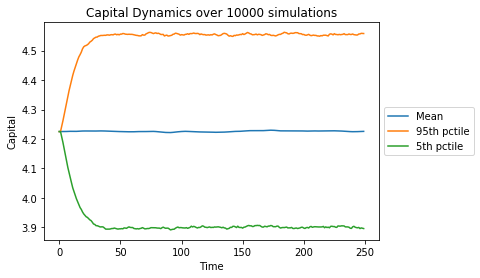

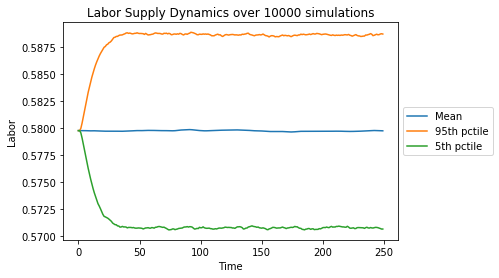

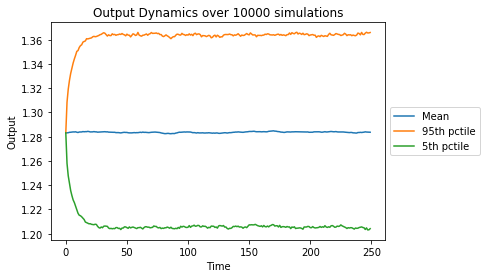

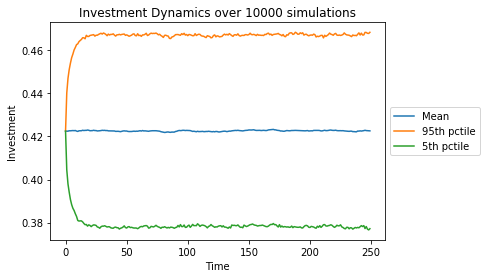

In [97]:
X_testing = [0, 0]
TSMatk, TSMatl, TSMatc, TSMatr, TSMatw, TSMaty, TSMati = simulate(m, X_testing, 0, 250, 10000)
Plot7()

### Exercise 8

In [98]:
#Means
Ystat = np.mean(TSMaty, axis=1)
Kstat = np.mean(TSMatk, axis=1)
Istat = np.mean(TSMati, axis=1)
Lstat = np.mean(TSMatl, axis=1)
print("MEANS: Average value and Standard Deviation \n", \
      "  Output: \t", Ystat.mean(), "\t", Ystat.std(), "\n", \
      "  Capital: \t", Kstat.mean(), "\t", Kstat.std(), "\n", \
      "  Investment: \t", Istat.mean(), "\t", Istat.std(), "\n", \
      "  Labor: \t", Lstat.mean(), "\t", Lstat.std(), "\n")

#Volatility
Ystat = np.std(TSMaty, axis=1)
Kstat = np.std(TSMatk, axis=1)
Istat = np.std(TSMati, axis=1)
Lstat = np.std(TSMatl, axis=1)
print("VOLATILITY: Average value and Standard Deviation \n", \
      "  Output: \t", Ystat.mean(), "\t", Ystat.std(), "\n", \
      "  Capital: \t", Kstat.mean(), "\t", Kstat.std(), "\n", \
      "  Investment: \t", Istat.mean(), "\t", Istat.std(), "\n", \
      "  Labor: \t", Lstat.mean(), "\t", Lstat.std(), "\n")

#Coefficient of Variation
Ystat = np.mean(TSMaty, axis=1)/np.std(TSMaty, axis=1)
Kstat = np.mean(TSMatk, axis=1)/np.std(TSMatk, axis=1)
Istat = np.mean(TSMati, axis=1)/np.std(TSMati, axis=1)
Lstat = np.mean(TSMatl, axis=1)/np.std(TSMatl, axis=1)
print("COEFFICIENT OF VARIATION: Average value and Standard Deviation \n", \
      "  Output: \t", Ystat.mean(), "\t", Ystat.std(), "\n", \
      "  Capital: \t", Kstat.mean(), "\t", Kstat.std(), "\n", \
      "  Investment: \t", Istat.mean(), "\t", Istat.std(), "\n", \
      "  Labor: \t", Lstat.mean(), "\t", Lstat.std(), "\n")

#Relative Volatility
Ystat = np.std(TSMaty, axis=1)/np.std(TSMaty, axis=1)
Kstat = np.std(TSMatk, axis=1)/np.std(TSMaty, axis=1)
Istat = np.std(TSMati, axis=1)/np.std(TSMaty, axis=1)
Lstat = np.std(TSMatl, axis=1)/np.std(TSMaty, axis=1)
print("RELATIVE VOLATILITY: Average value and Standard Deviation \n", \
      "  Output: \t", Ystat.mean(), "\t", Ystat.std(), "\n", \
      "  Capital: \t", Kstat.mean(), "\t", Kstat.std(), "\n", \
      "  Investment: \t", Istat.mean(), "\t", Istat.std(), "\n", \
      "  Labor: \t", Lstat.mean(), "\t", Lstat.std(), "\n")

#The next two are a little more involved to compute
#Persistence
Ystat = np.zeros(10000)
for i in range(10000):
    Ystat[i]= np.corrcoef(TSMaty[i,1:], TSMaty[i,:-1])[0,1]

Kstat = np.zeros(10000)
for i in range(10000):
    Kstat[i]= np.corrcoef(TSMatk[i,1:], TSMatk[i,:-1])[0,1]

Istat = np.zeros(10000)
for i in range(10000):
    Istat[i]= np.corrcoef(TSMati[i,1:], TSMati[i,:-1])[0,1]

Lstat = np.zeros(10000)
for i in range(10000):
    Lstat[i]= np.corrcoef(TSMatl[i,1:], TSMatl[i,:-1])[0,1]

print("PERSISTENCE: Average value and Standard Deviation \n", \
      "  Output: \t", Ystat.mean(), "\t", Ystat.std(), "\n", \
      "  Capital: \t", Kstat.mean(), "\t", Kstat.std(), "\n", \
      "  Investment: \t", Istat.mean(), "\t", Istat.std(), "\n", \
      "  Labor: \t", Lstat.mean(), "\t", Lstat.std(), "\n")

#Cyclicality
Ystat = np.zeros(10000)
for i in range(10000):
    Ystat[i]= np.corrcoef(TSMaty[i,:], TSMaty[i,:])[0,1]

Kstat = np.zeros(10000)
for i in range(10000):
    Kstat[i]= np.corrcoef(TSMatk[i,:], TSMaty[i,:])[0,1]

Istat = np.zeros(10000)
for i in range(10000):
    Istat[i]= np.corrcoef(TSMati[i,:], TSMaty[i,:])[0,1]

Lstat = np.zeros(10000)
for i in range(10000):
    Lstat[i]= np.corrcoef(TSMatl[i,:], TSMaty[i,:])[0,1]

print("CYCLICALITY: Average value and Standard Deviation \n", \
      "  Output: \t", Ystat.mean(), "\t", Ystat.std(), "\n", \
      "  Capital: \t", Kstat.mean(), "\t", Kstat.std(), "\n", \
      "  Investment: \t", Istat.mean(), "\t", Istat.std(), "\n", \
      "  Labor: \t", Lstat.mean(), "\t", Lstat.std(), "\n")


MEANS: Average value and Standard Deviation 
   Output: 	 1.283695786898378 	 0.015845301450301413 
   Capital: 	 4.225996413372795 	 0.07595912867997948 
   Investment: 	 0.4226023980448933 	 0.007800945874010725 
   Labor: 	 0.5797705031243218 	 0.0020751765796581407 

VOLATILITY: Average value and Standard Deviation 
   Output: 	 0.04404386228527168 	 0.007608031948851245 
   Capital: 	 0.1727710222190257 	 0.03936827849510837 
   Investment: 	 0.025306577100728544 	 0.0036832918270614788 
   Labor: 	 0.00471284769426979 	 0.0010770123719315698 

COEFFICIENT OF VARIATION: Average value and Standard Deviation 
   Output: 	 30.011169971228117 	 5.164148270490579 
   Capital: 	 25.77660240079372 	 6.10439827579319 
   Investment: 	 17.050560451789696 	 2.4824137793396868 
   Labor: 	 129.6925917273466 	 30.782507987828875 

RELATIVE VOLATILITY: Average value and Standard Deviation 
   Output: 	 1.0 	 0.0 
   Capital: 	 3.8882530599983016 	 0.26648693895148645 
   Investment: 	 0.577378

### Exercise 9

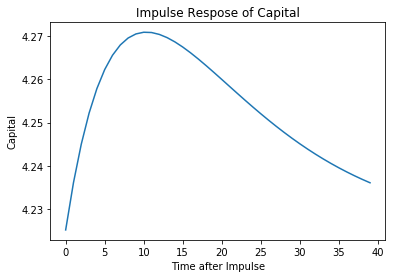

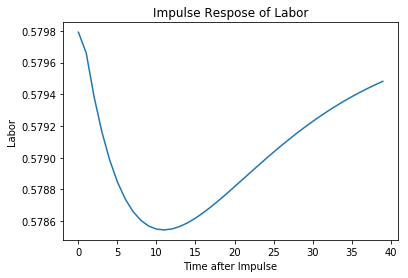

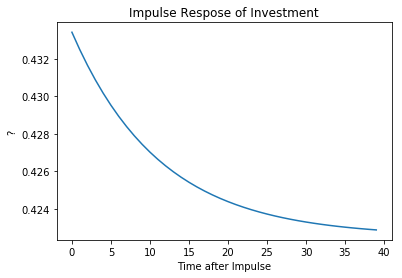

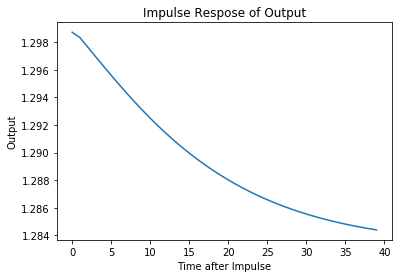

In [100]:
def impulsesim(m, X, T, imp):
    '''
    This function does basically the same thing as simtimeseries, but
    now it controls the shocks to give a big impulse in the first 
    period which then decays. 
    '''
    X_t = X
    X_tp1 = X_t
    z_t = imp
    klist = []
    llist = []
    clist = []
    rlist = []
    wlist = []
    ylist = []
    ilist = []
    for i in range(T):
        #Get next period choices, shock
        X_tp1 = statenext(m, X_t, z_t) 
        z_tp1 = z_t * m.rho
        #Store period's values        
        k_t = X_t[0] + k_ss
        k_tp1 = X_tp1[0] + k_ss
        l_t = X_t[1] + l_ss
        cstore, rstore, Tstore, wstore = Definitions(m, k_tp1, k_t, l_t, z_t)
        istore = k_tp1 - (1 - m.delta)* k_t
        ystore = f(m, k_t, l_t, z_t)
        klist.append(k_t)
        llist.append(l_t)
        ylist.append(ystore)
        clist.append(cstore)
        rlist.append(rstore)
        wlist.append(wstore)
        ilist.append(istore)
        # Roll over state, shock to next period
        X_t = X_tp1
        z_t = z_tp1
    return klist, llist, clist, rlist, wlist, ylist, ilist

X_ss = [0, 0]
statenext(m, X_ss, 0)
klist, llist, clist, rlist, wlist, ylist, ilist = impulsesim(m, X_ss, 40, m.sigma)
plt.plot(klist)
plt.title("Impulse Respose of Capital")
plt.ylabel("Capital")
plt.xlabel("Time after Impulse")
plt.show()

plt.plot(llist)
plt.title("Impulse Respose of Labor")
plt.ylabel("Labor")
plt.xlabel("Time after Impulse")
plt.show()

plt.plot(ilist)
plt.title("Impulse Respose of Investment")
plt.ylabel("?")
plt.xlabel("Time after Impulse")
plt.show()

plt.plot(ylist)
plt.title("Impulse Respose of Output")
plt.ylabel("Output")
plt.xlabel("Time after Impulse")
plt.show()

### Exercise 10